# 高级车道线检测
在这个项目中，我们使用计算机视觉技术来检测道路车道线，估计道路曲率以及车子距离中心的偏离程度。
寻找车道线的流程如下：
>* 摄像头校准
>* 对原始图像使用失真校准
>* 使用图像处理技术来生成一个二值化图像
>* 利用透视变换来修正二值化图像
>* 检测车道像素，并拟合来找到车道边界
>* 决定车道曲率及车辆的位置
>* 在原始图像上包裹监测到的车道边界
>* 完成车道曲率与车辆位置的可视化

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from skimage import morphology
from collections import deque
%matplotlib inline

In [2]:
#Display
showMe = 0
def display(img,title,color=1):
    '''
    display image
    img: rgb or grayscale
    title:figure title
    color:show image in color(1) or grayscale(0)
    '''
    if color:
        plt.imshow(img)
    else:
        plt.imshow(img,cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Calibration Camera
接下来我们来实现摄像头校准的函数
reference [url](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html?highlight=findchessboardcorners)

RMS Error of Camera calibration:1.030
This number must be between 0.1 and 1.0


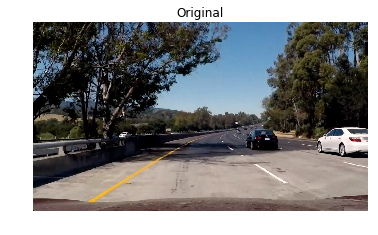

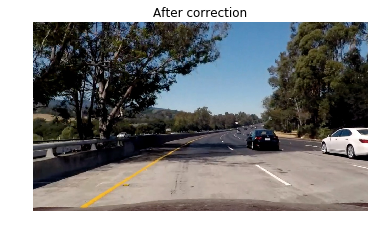

In [84]:
def camera_calibration(folder,nx,ny,showMe=0):
    '''
    使用opencv的findChessBoardCorners函数来找到所有角落的(x,y)坐标
    folder:校准图像的目录
    nx:x轴方向期望的角落个数
    ny:y轴方向期望的角落个数
    返回一个字典：
    ret:校正的RMS误差
    mtx:摄像头矩阵
    dist:畸变系数
    rvecs:旋转向量
    tvecs：平移向量
    '''
    
    #存储物体实际三维空间坐标及图像中图像的坐标
    objpoints = []#3D
    imgpoints = []
    objp = np.zeros((nx*ny,3),np.float32)
    #print(objp.shape)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)   
    assert len(folder)!=0
    for fname in folder:
        img = cv2.imread(fname)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        ret,corners = cv2.findChessboardCorners(gray,(nx,ny))
        img_sz = gray.shape[::-1]#倒序输出
        #print(corners)
        #if ret is True , find corners
        if ret:
            imgpoints.append(corners)
            objpoints.append(objp)
            if showMe:
                draw_corners = cv2.drawChessboardCorners(img,(nx,ny),corners,ret)
                display(draw_corners,'Found all corners:{}'.format(ret))
    if len(objpoints)==len(imgpoints) and len(objpoints)!=0:
        ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,img_sz,None,None)
        return {'ret':ret,'cameraMatrix':mtx,'distorsionCoeff':dist,\
               'rotationVec':rvecs,'translationVec':tvecs}
    else:
        raise  Error('Camera Calibration failed')
def correction(image,calib_params,showMe=0):
    '''
    失真矫正
    calib_params:由摄像头矫正返回的矫正参数
    '''
    corrected = cv2.undistort(image,calib_params['cameraMatrix'],calib_params['distorsionCoeff'],\
                              None,calib_params['cameraMatrix'])
    if showMe:
        display(image,'Original',color=1)
        display(corrected,'After correction',color=1)
    return corrected
nx = 9
ny = 6
folder_calibration = glob.glob("camera_cal/calibration*.jpg")
calib_params = camera_calibration(folder_calibration,nx,ny,showMe=0)
print('RMS Error of Camera calibration:{:.3f}'.format(calib_params['ret']))
print('This number must be between 0.1 and 1.0')
imgs_tests = glob.glob("test_images/*.jpg")
original_img = np.random.choice(imgs_tests)
original_img = cv2.imread("test_images/test5.jpg")
original_img = cv2.cvtColor(original_img,cv2.COLOR_BGR2RGB)
corr_img = correction(original_img,calib_params,showMe=1)

# Image Process
接下来我们需要完成图像处理函数
具体处理流程如下图所示：

XXXXXXXXX
XXXXXXXXX
接下来我们来实现Image process中的函数


In [86]:
#原始图像通过image_correction()函数来校准。它的输入参数是：图像，摄像头矩阵迹失真系数，返回值是校准后的图像 
class ImageProcess():
    def __init__(self):
        pass
    
    def gaussianBlur(self,img,k_sz=5):
        img = cv2.GaussianBlur(img,(k_sz,k_sz),0)
        return img
    
    def directional_gradient(self,img,direction='x',thresh=[0,255]):
        '''
        使用Opencv Sobel算子来求方向梯度
        img:Grayscale
        direction:x or y axis
        thresh:apply threshold on pixel intensity of gradient image
        output is binary image
        '''
        if direction=='x':
            sobel = cv2.Sobel(img,cv2.CV_64F,1,0)
        elif direction=='y':
            sobel = cv2.Sobel(img,cv2.CV_64F,0,1)
        
        sobel_abs = np.absolute(sobel)#absolute value
        scaled_sobel = np.uint8(sobel_abs*255/np.max(sobel_abs))
        binary_output = np.zeros_like(sobel)
        binary_output[(scaled_sobel>=thresh[0])&(scaled_sobel<=thresh[1])] = 1
        return binary_output
    
    def mag_gradient(self,img,thresh=[0,255]):
        '''
        将方向梯度结合
        Magnitude of gradient:sqrt(gradx**2+grady**2)
        img:RGB or Grayscale image
        thresh:apply threshold on pixel intensity of gradient magnitude
        output is a binary image
        '''
        sobelx = cv2.Sobel(img,cv2.CV_64F,1,0)
        sobely = cv2.Sobel(img,cv2.CV_64F,0,1)
        gradient_mag = np.sqrt(np.square(sobelx)+np.square(sobely))
        scaled_gradient_mag = np.uint8(gradient_mag*255/np.max(gradient_mag))
        binary_output = np.zeros_like(gradient_mag)
        binary_output[(scaled_gradient_mag>=thresh[0])&(scaled_gradient_mag<=thresh[1])]=1
        return binary_output
    
    def gradient_direction(self,img,thresh=[0,90],ksize=3):
        '''
        Direction of gradient:arctan(gray/grax)
        img:RGB or Grayscale image
        thresh:apply threshold on gradient direction in degrees(0,90)
        ksize:kernel size
        output:binary image
        '''
        sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize)
        sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize)
        gradient_dir = np.arctan2(sobely,sobelx)
        thresh = [thresh[0]*np.pi/180,thresh[1]*np.pi/180]
        binary_output = np.zeros_like(gradient_dir)
        binary_output[(gradient_dir>=thresh[0])&(gradient_direction<=thresh[1])]=1
        return binary_output
    
    def color_binary(self,img,dst_format='HLS',ch=2,ch_thresh=[0,255]):
        '''
        Color thresholding on channel ch
        img:RGB
        dst_format:destination format(HLS or HSV)
        ch_thresh:pixel intensity threshold on channel ch
        output is binary image
        '''
        if dst_format =='HSV':
            img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
            ch_binary = np.zeros_like(img[:,:,int(ch-1)])
            ch_binary[(img[:,:,int(ch-1)]>=ch_thresh[0])&(img[:,:,int(ch-1)]<=ch_thresh[1])] = 1
        else:
            img = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
            ch_binary = np.zeros_like(img[:,:,int(ch-1)])
            ch_binary[(img[:,:,int(ch-1)]>=ch_thresh[0])&(img[:,:,int(ch-1)]<=ch_thresh[1])] = 1
        return ch_binary
    
    def image_correction(self,img,cal_params):
        '''
        correct image from camera distorsion
        img :original image RGB format
        cal_params:calibration parameters of camera(Camera Matrix and distorsion Coefficients)
        return undistorted image
        '''
        dst = cv2.undistort(img,cal_params['cameraMatrix'],\
                           cal_params['distorsionCoeff'],None,\
                           cal_params['cameraMatrix'])
        return dst
    
    def convert2_rgb(sef,img):
        try:
            rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            return rgb
        except:
            print('image cannot be convert to RGB')
    
    def convert2_gray(self,img):
        if len(img.shape)==3:
            gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
            return gray
        elif len(img.shape)==2:
            return img
    
    def birdView(self,img,M):
        '''
        Transform image to birdeye view
        img:binary image
        M:transformation matrix
        return a wraped image
        '''
        img_sz = (img.shape[1],img.shape[0])
        img_warped = cv2.warpPerspective(img,M,img_sz,flags = cv2.INTER_LINEAR)
        
        return img_warped

# Perspective Transform
这一步我将利用前面的ImageProcess类中的birds_eye()来实现将undistorted image to a 'birds eye view' of the road.这样操作后将有利于后面我们来拟合直线及测量曲率

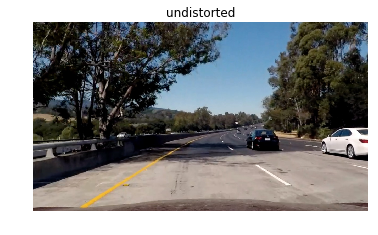

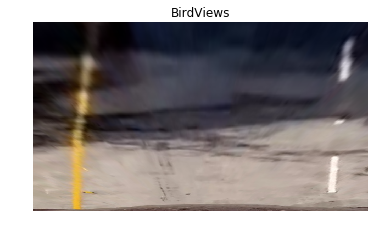

In [87]:
def perspective_transform(src_pts,dst_pts):
    '''
    perspective transform
    args:source and destiantion points
    return M and Minv
    '''
    M = cv2.getPerspectiveTransform(src_pts,dst_pts)
    Minv = cv2.getPerspectiveTransform(dst_pts,src_pts)
    return {'M':M,'Minv':Minv}
# original image to bird view (transformation)
src_pts = np.float32([[240,720],[575,470],[735,470],[1200,720]])
dst_pts = np.float32([[240,720],[240,0],[1200,0],[1200,720]])
transform_matrix = perspective_transform(src_pts,dst_pts)
imageprocess = ImageProcess()
warp_image = imageprocess.birdView(corr_img,transform_matrix['M'])
display(corr_img,'undistorted',color=1)
display(warp_image,'BirdViews',color=1)

In [88]:
print(corr_img.shape)

(720, 1280, 3)


# Apply Binary Thresholds
在这一步，我们努力尝试将birdview image转换到不同颜色空间，我们希望通关颜色空间的转换使得我们能够很清晰的突出车道线并忽略其他不相关的东西。通过实验我们观察出一下结论：
>* HLS色彩空间的S色道，在阈值范围为180-255的情况下，可以很好的识别白线和黄线，但是并不能100%保留所有像素，且容易被阴影所干扰
>* HUV色彩空间的L色道，在阈值范围为225-255的情况下，几乎可以完美识别白线，但是完全忽略了黄线
>* RGB色彩空间的B色道，在阈值范围为155-200的情况下，几乎可以完美识别黄线，但是完全忽略了白线

我们可以结合上述三个结论来很好的凸显黄线与白线

**NOTE**:
S阈值被结合阈值法排除，因为在实际检测车道线的过程中，该方法增加了额外的噪声

# Line Detection and fitting

In [117]:
import matplotlib.patches as patches
from scipy.stats import iqr

class Line():
    '''
    extract pixels associated with lanes and fit them to 2nd order polynomial function
    '''
    def __init__(self,buffer_sz,showMe):
        self.buffer_sz = buffer_sz
        self.allx = deque([],maxlen=self.buffer_sz)
        self.ally = deque([],maxlen=self.buffer_sz)
        
        self.bestfit = {'a0':deque([],maxlen=self.buffer_sz),
                       'a1':deque([],maxlen = self.buffer_sz),
                       'a2':deque([],maxlen=self.buffer_sz)}
        self.bestfit_real = {'a0':deque([],maxlen=self.buffer_sz),
                            'a1':deque([],maxlen=self.buffer_sz),
                            'a2':deque([],maxlen=self.buffer_sz)}
        self.radOfCurv_tracker = deque([],maxlen=self.buffer_sz)
        self.showMe = showMe
        self.starter_centroid = None
        self.line_detected = False
        
    def MahalanobisDist(self,x,y):
        '''
        Mahalanobis Distance for bi-variate distribution
        D_M(x) = \sqrt{(x - \mu)^T \Sigma^{-1} (x-\mu)}(latex)
        '''
        covariance_xy = np.cov(x,y,rowvar=0)
        inv_covariance_xy = np.linalg.inv(covariance_xy)
        xy_mean = np.mean(x),np.mean(y)
        x_diff = np.array([x_i-xy_mean[0] for x_i in x])
        y_diff = np.array([y_i-xy_mean[1] for y_i in y])
        diff_xy = np.transpose([x_diff,y_diff])
        
        md = []
        for i in range(len(diff_xy)):
            md.append(np.sqrt(np.dot(np.dot(np.transpose(diff_xy[i]),inv_covariance_xy),diff_xy[i])))
        return md
    
    def MD_removeOutliers(self,x,y,MD_thresh):
        '''
        remove pixels outliers using Mahalonobis distance
        '''
        MD = self.MahalanobisDist(x,y)
        threshold = np.mean(MD)*MD_thresh
        nx,ny,outliers = [],[],[]
        for i in range(len(MD)):
            if MD[i]<=threshold:
                nx.append(x[i])
                ny.append(y[i])
            else:
                outliers.append(i)
        return (nx,ny)
    
    def polynomial_fit(self,data):
        '''
        多项式拟合
        a0+a1 x+a2 x**2
        data:dictionary with x and y values{'x':[],'y':[]}
        '''
        a2,a1,a0 = np.polyfit(data['x'],data['y'],2)
        return {'a0':a0,'a1':a1,'a2':a2}
    
    def find_starter_centroids(self,image,x0,peak_thresh,showMe):
        '''
        find starter centroids using histogram
        peak_thresh:if peak intensity is below a threshold use histogram on the full height of the image
        returns x-position of centroid and peak intensity
        '''
        window = {'x0':x0,'y0':image.shape[0],'width':image.shape[1]/2,'height':image.shape[0]/2}
        
        # get centroid
        centroid , peak_intensity,_ = self.find_centroid(image,peak_thresh,window,showMe)
        if peak_intensity<peak_thresh:
            window['height'] = image.shape[0]
            centroid,peak_intensity,_ = self.find_centroid(image,peak_thresh,window,showMe)
        return {'centroid':centroid,'intensity':peak_intensity}
    
    def find_centroid(self,image,peak_thresh,window,showMe):
        '''
        find centroid in a window using histogram of hotpixels
        img:binary image
        window with specs {'x0','y0','width','height'}
        (x0,y0) coordinates of bottom-left corner of window
        return x-position of centroid ,peak intensity and hotpixels_cnt in window
        '''
        #crop image to window dimension 
        mask_window = image[round(window['y0']-window['height']):round(window['y0']),
                           round(window['x0']):round(window['x0']+window['width'])]
        histogram = np.sum(mask_window,axis=0)
        centroid = np.argmax(histogram)
        hotpixels_cnt = np.sum(histogram)
        peak_intensity = histogram[centroid]
        if peak_intensity<=peak_thresh:
            centroid = int(round(window['x0']+window['width']/2))
            peak_intensity = 0
        else:
            centroid = int(round(centroid+window['x0']))
        
        if showMe:
            plt.plot(histogram)
            plt.title('Histogram')
            plt.xlabel('horzontal position')
            plt.ylabel('hot pixels count')
            plt.show()
        return (centroid,peak_intensity,hotpixels_cnt)
    
    def run_sliding_window(self,image,centroid_starter,sliding_window_specs,showMe = showMe):
        '''
        Run sliding window from bottom to top of the image and return indexes of the hotpixels associated with lane
        image:binary image
        centroid_starter:centroid starting location sliding window
        sliding_window_specs:['width','n_steps']
            width of sliding window
            number of steps of sliding window alog vertical axis
        return {'x':[],'y':[]}
            coordiantes of all hotpixels detected by sliding window
            coordinates of alll centroids recorded but not used yet!        
        '''
        #Initialize sliding window
        window = {'x0':centroid_starter-int(sliding_window_specs['width']/2),\
                 'y0':image.shape[0],
                 'width':sliding_window_specs['width'],
                 'height':round(image.shape[0]/sliding_window_specs['n_steps'])}
        
        #
        hotpixels_log = {'x':[],'y':[]}
        centroids_log = []
        if showMe:
            out_img = (np.dstack((image,image,image))*255).astype('uint8')
        for step in range(sliding_window_specs['n_steps']):
            if window['x0']<0: window['x0'] = 0
            if (window['x0']+sliding_window_specs['width'])>image.shape[1]:
                window['x0'] = image.shape[1] - sliding_window_specs['width']
            
            centroid,peak_intensity,hotpixels_cnt = self.find_centroid(image,peak_thresh,window,showMe=showMe)
            if step==0:
                self.starter_centroid = centroid
            if hotpixels_cnt/(window['width']*window['height'])>0.6:
                window['width'] = window['width']*2
                window['x0']  = round(window['x0']-window['width']/2)
                if (window['x0']<0):window['x0']=0
                if (window['x0']+window['width'])>image.shape[1]:
                    window['x0'] = image.shape[1]-window['width']
                centroid,peak_intensity,hotpixels_cnt = self.find_centroid(image,peak_thresh,window,showMe=showMe)          
                
            if showMe:
                print('peak intensity{}'.format(peak_intensity))
                print('This is centroid:{}'.format(centroid))
            mask_window = np.zeros_like(image)
            mask_window[window['y0']-window['height']:window['y0'],
                       window['x0']:window['x0']+window['width']]\
             = image[window['y0']-window['height']:window['y0'],
                    window['x0']:window['x0']+window['width']]
            
            hotpixels = np.nonzero(mask_window)
            #print(hotpixels_log['x'])
            
            hotpixels_log['x'].extend(hotpixels[0].tolist())
            hotpixels_log['y'].extend(hotpixels[1].tolist())
            # update record of centroid
            centroids_log.append(centroid)
            
            if showMe:
                cv2.rectangle(out_img,
                             (window['x0'],window['y0']-window['height']),
                             (window['x0']+window['width'],window['y0']),(0,255,0),2)
                plt.imshow(out_img)
                plt.show()
            
            # set next position of window and use standard sliding window width
            window['width'] = sliding_window_specs['width']
            window['x0'] = round(centroid-window['width']/2)
            window['y0'] = window['y0'] - window['height']
        return hotpixels_log
    
    def predict_line(self,x0,xmax,coeffs):
        '''
        predict road line using polyfit cofficient
        x vaues are in range (x0,xmax)
        polyfit coeffs:{'a2':,'a1':,'a2':}
        returns array of [x,y] predicted points ,x along image vertical / y along image horizontal direction
        '''
        x_pts = np.linspace(x0,xmax-1,num=xmax)
        pred = coeffs['a2']*x_pts**2+coeffs['a1']*x_pts+coeffs['a0']
        return np.column_stack((x_pts,pred))
    
    def update_tracker(self,tracker,new_value):
        '''
        update tracker(self.bestfit or self.bestfit_real or radO Curv or hotpixels) with new coeffs
        new_coeffs is of the form {'a2':[val2,...],'a1':[va'1,...],'a0':[val0,...]}
        tracker is of the form {'a2':[val2,...]}
        update tracker of radius of curvature
        update allx and ally with hotpixels coordinates from last sliding window
        '''
        if tracker =='bestfit':
            self.bestfit['a0'].append(new_value['a0'])
            self.bestfit['a1'].append(new_value['a1'])
            self.bestfit['a2'].append(new_value['a2'])
        elif tracker == 'bestfit_real':
            self.bestfit_real['a0'].append(new_value['a0'])
            self.bestfit_real['a1'].append(new_value['a1'])
            self.bestfit_real['a2'].append(new_value['a2'])
        elif tracker == 'radOfCurvature':
            self.radOfCurv_tracker.append(new_value)
        elif tracker == 'hotpixels':
            self.allx.append(new_value['x'])
            self.ally.append(new_value['y'])
        
    def compute_radOfCurvature(self,coeffs,pt):
        return ((1+(2*coeffs['a2']*pt+coeffs['a1'])**2)**1.5)/np.absolute(2*coeffs['a2'])
    
    def intercept_is_outlier(self,data,elt):
        '''
        Determine if intercept 'elt' is an outlier when compared to previous 'intercepts'
        in data
        returns True if elt is an outlier
        '''
        oulier_flag = False
        if len(data)==self.buffer_sz:
            p = np.min(data)-50
            q = np.max(data)+50
            if elt < q and elt > p:
                return False
            else:
                return True
    def is_outlier(self,data,elt):
        '''
        Determine 
        '''
        outlier_flag = False
        if len(data) == self.buffer_sz:
            q1 = np.percentile(data,25)
            q3 = np.percentile(data,75)
            iqr = q3-q1
            if elt < (q3+1.5*iqr) and elt>q1-1.5*iqr:
                return False
            else:
                return True
    
    def approve_line(self,coeffs,xmax):
        '''
        Approve if detected hotpixels are from a real line road
        Scheme: if intercept of bestfitat 0 and xmax(bottom of image) agrees with previous frame, then flag True
        output:flag
        '''
        flag_line = True
        if self.intercept_is_outlier(self.bestfit['a0'],coeffs['a0']):
            flag_line = False
        
        intercepts_bottom = np.array(self.bestfit['a2'])*xmax**2 + np.array(self.bestfit['a1'])*xmax\
        +np.array(self.bestfit['a0'])
        this_intercepts_bottom = coeffs['a2']*xmax**2 + coeffs['a1']*xmax + coeffs['a0']
        if self.intercept_is_outlier(intercepts_bottom,this_intercepts_bottom):
            flag_line = False
        return flag_line
    
    def mva_smoothing(self,tracker,weighted=False):
        '''
        Moving average smoothing of polyfit coefficients
        weighted:true ,use weighted average
        (1a+1/2b+1/3c...)/(1+1/2+1/3...) where a is the most recent frame,b 2nd most recent ,etc...
        False:use mean
        '''
        if weighted:
            if tracker == 'coeffs':
                smooth_tracker = {'a2':0,'a1':0,'a0':0}
                a2,a1,a0,denominator = 0,0,0,0
                #print(len(self.bestfit['a2']))
                for i in range(len(self.bestfit['a2'])):
                    a2 = a2 + self.bestfit['a2'][i] / abs(len(self.bestfit['a2'])-i)
                    a1 = a1 + self.bestfit['a1'][i] / abs(len(self.bestfit['a2'])-i)
                    a0 = a0 + self.bestfit['a0'][i] / abs(len(self.bestfit['a2'])-i)
                    denominator = denominator + 1/abs(len(self.bestfit['a2'])-i)
                #print(denominator)
                smooth_tracker['a2'] = a2 / denominator
                smooth_tracker['a1'] = a1 / denominator
                smooth_tracker['a0'] = a0 / denominator
                return smooth_tracker
            elif tracker == 'radCurv':
                smooth_val,denominator = 0, 0
                for i in range(len(self.radOfCurv_tracker)):
                    smooth_val = smooth_val + self.radOfCurv_tracker[i]/abs(len(self.radOfCurv_tracker)-i)
                    denominator = denominator+ 1/abs(len(self.radOfCurv_tracker)-i)
                return smooth_val/denominator
        else:
            if tracker=='coeffs':
                smooth_coeffs = {'a2':0,'a1':0,'a0':0}
                smooth_coeffs['a2'] = np.mean(self.bestfit['a2'])
                smooth_coeffs['a1'] = np.mean(self.bestfit['a1'])
                smooth_coeffs['a0'] = np.mean(self.bestfit['a0'])
                return smooth_coeffs
            elif tracker=='radCurv':
                return np.mean(self.radOfCurv_tracker)

# Pipeline



In [115]:
camera_calib = calib_params
gradx_thresh = [25,255]
ch_thresh = [50,255]
showMe = 0
bottom_crop = -40
sliding_window_specs = {'width':120,'n_steps':10}
peak_thresh = 10
buffer_sz = 1
ym_per_pix = 12/450
xm_per_pix = 3.7/911

min_sz = 50
apply_MDOutlier = False
MD_thresh = 1.8

lineLeft = Line(buffer_sz=buffer_sz,showMe=showMe)
lineRight = Line(buffer_sz=buffer_sz,showMe=showMe)
alpha = None

def pipeline(image):
    global transform_matrix,lineLeft,lineRight
    process = ImageProcess()
    #print(transform_matrix)
    img_sz  = (image.shape[1],image.shape[0])
    pt_curvature = image.shape[0]
    original = image.copy()
    image = process.image_correction(image,camera_calib)
    if showMe:
        display(image,'Apply Camera Correction',color=1)
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    if showMe:
        display(gray,'Gray',color=0)
    gradx = process.directional_gradient(gray,direction='x',thresh = gradx_thresh)
    if showMe:
        display(gradx,'Gradent x',color=0)
    ch3_hls_binary = process.color_binary(image,dst_format='HLS',ch=3,ch_thresh=ch_thresh)
    if showMe:
        display(ch3_hls_binary,'HLS to Binary S',color=0)
    combined_output = np.zeros_like(gradx)
    combined_output[((gradx==1)|(ch3_hls_binary==1))] = 1
    if showMe:
        display(combined_output,'Combined output',color=0)
    
    #Apply ROI MASK
    mask = np.zeros_like(combined_output)
    vertices = np.array([[(100,720),(545,470),(755,470),(1290,720)]],dtype=np.int32)
    cv2.fillPoly(mask,vertices,1)
    masked_image = cv2.bitwise_and(combined_output,mask)
    if showMe:
        display(masked_image,'Masked',color=0)
    
    cleaned = morphology.remove_small_objects(masked_image.astype('bool'),min_size=min_sz,connectivity=2)
    if showMe:
        display(cleaned,'cleaned',color=0)
    
    wraped_img = process.birdView(cleaned*1.0,transform_matrix['M'])
    if showMe:
        display(wraped_img,'Bird View',color=0)
    wraped_img = wraped_img[0:bottom_crop,:]
    
    if lineRight.line_detected ==False:
        centroid_starter_right = lineRight.find_starter_centroids(wraped_img,x0=wraped_img.shape[1]/2,
                                                                 peak_thresh = peak_thresh,showMe = showMe)
        lineRight.starter_centroid = centroid_starter_right['centroid']
        lineRight.line_detected = True
    log_lineRight = lineRight.run_sliding_window(wraped_img,lineRight.starter_centroid,sliding_window_specs,showMe=showMe)
    if lineLeft.line_detected == False:
        centroid_starter_left = lineLeft.find_starter_centroids(wraped_img,x0=0,peak_thresh=peak_thresh,
                                                               showMe = showMe)
        lineLeft.starter_centroid = centroid_starter_left['centroid']
        lineLeft.line_detected = True
    
    log_lineLeft = lineLeft.run_sliding_window(wraped_img,lineLeft.starter_centroid,
                                              sliding_window_specs,showMe=showMe)
    if apply_MDOutlier:
        log_lineRight['x'],log_lineRight['y'] = \
        lineRight.MD_removeOutliers(log_lineRight['x'],log_lineRight['y'],MD_thresh)
        log_lineLeft['x'],log_lineLeft['y'] = \
        lineLeft.MD_removeOutliers(log_lineLeft['x'],log_lineLeft['y'],MD_thresh)
    if len(log_lineRight['x'])!=0:
        lineRight.update_tracker('hotpixels',log_lineRight)
    else:
        lineRight.line_detected = False
    
    if len(log_lineLeft['x'])!=0:
        lineLeft.update_tracker('hotpixels',log_lineLeft)
    else:
        lineLeft.line_detected = False
    
    multiframe_r = {'x':[val for sublist in lineRight.allx for val in sublist],
                   'y':[val for sublist in lineRight.ally for val in sublist]}
    multiframe_l = {'x':[val for sublist in lineLeft.allx for val in sublist],
                   'y':[val for sublist in lineLeft.ally for val in sublist]}
    
    fit_lineRight = lineRight.polynomial_fit(multiframe_r)
    fit_lineRight_real = lineRight.polynomial_fit({'x':[i*ym_per_pix for i in multiframe_r['x']],
                                             'y':[i*xm_per_pix for i in multiframe_r['y']]})
    fit_lineLeft = lineLeft.polynomial_fit(multiframe_l)
    fit_lineLeft_real = lineLeft.polynomial_fit({'x':[i*ym_per_pix for i in multiframe_l['x']],
                                             'y':[i*xm_per_pix for i in multiframe_l['y']]})
    
    if lineRight.approve_line(fit_lineRight,xmax=image.shape[0]):
        #update trackers
        lineRight.update_tracker('bestfit',fit_lineRight)
        lineRight.update_tracker('bestfit_real',fit_lineRight_real)
        radOfCurv_r = lineRight.compute_radOfCurvature(fit_lineRight_real,pt_curvature*ym_per_pix)
        lineRight.update_tracker('radOfCurvature',radOfCurv_r)
    else:
        fit_lineRight = {'a2':lineRight.bestfit['a2'][-1],'a1':lineRight.bestfit['a1'][-1],
                        'a0':lineRight.bestfit['a0'][-1]}
        radOfCurv_r = lineRight.radOfCurv_tracker[-1]
    if lineLeft.approve_line(fit_lineLeft,xmax=image.shape[0]):
        #update tracker
        lineLeft.update_tracker('bestfit',fit_lineLeft)
        lineLeft.update_tracker('bestfit_real',fit_lineLeft_real)
        radOfCurv_l = lineLeft.compute_radOfCurvature(fit_lineLeft_real,pt_curvature*ym_per_pix)
        lineLeft.update_tracker('radOfCurvature',radOfCurv_l)
    else:
        fit_lineLeft = {'a2':lineLeft.bestfit['a2'][-1],
                       'a1':lineLeft.bestfit['a1'][-1],
                       'a0':lineLeft.bestfit['a0'][-1]}
        radOfCurv_l = lineLeft.radOfCurv_tracker[-1]
    #display lane 
    var_pts = np.linspace(0,image.shape[0]-1,num=image.shape[0])
    if showMe:
        plt.imshow(wraped_img,cmap='gray')
        plt.scatter(multiframe_r['y'],multiframe_r['x'],color='cyan',s=0.1,alpha=0.1)
        plt.scatter(multiframe_l['y'],multiframe_l['x'],color='cyan',s=0.1,alpha=0.1)
        # Show best fit on multiframe
        pred_lineRight = lineRight.predict_line(0,image.shape[0],fit_lineRight)
        pred_lineLeft = lineLeft.predict_line(0,image.shape[0],fit_lineLeft)
        plt.plot(pred_lineLeft[:,1],pred_lineLeft[:,0],'r--',label='multiframe',linewidth=3)
        plt.plot(pred_lineRight[:,1],pred_lineRight[:,0],'r--',label='multiframe',linewidth=3)
        plt.title('accum_fr(cyan)-bestfit on lfr(b) - bestfit acc_fr(r)')
        
        fit_lineRight_singleframe = lineRight.polynomial_fit(log_lineRight)
        fit_lineLeft_singleframe = lineLeft.polynomial_fit(log_lineLeft)
        var_pts = np.linsapce(0,image.shape[0]-1,num=image.shape[0])
        pred_lineLeft_singleframe = lineLeft.predict_line(0,image.shape[0],fit_lineLeft_singleframe)
        pred_lineRight_sigleframe = lineRight.predict_line(0,image.shape[0],fit_lineRight_singleframe)
        plt.plot(pred_lineLeft_singleframe[:,1],pred_lineLeft_singleframe[:,0],'b-',label='singleframe',linewidth=1)
        plt.plot(pred_lineRight_sigleframe[:,1],pred_lineRight_sigleframe[:,0],'b-',label='singleframe',linewidth=1)
        plt.show()
    smoothfit_lineLeft = lineLeft.mva_smoothing('coeffs',weighted=True)
    radCurv_smooth_lineLeft = lineLeft.mva_smoothing('radCurv',weighted=True)
    smoothfit_lineRight = lineRight.mva_smoothing('coeffs',weighted=True)
    radCurv_smooth_lineRight = lineRight.mva_smoothing('radCurv',weighted=True)
    
    pred_smooth_lineLeft = lineLeft.predict_line(0,image.shape[0],smoothfit_lineLeft)
    pred_smooth_lineRight = lineRight.predict_line(0,image.shape[0],smoothfit_lineRight)
    
    if showMe:
        plt.imshow(warped_img,cmap='gray')
        plt.plot(pred_smooth_lineLeft[:,1],pred_smooth_lineLeft[:,0],'r-')
        plt.plot(pred_smooth_lineRight[:,1],pred_smooth_lineRight[:,0],'r-')
        plt.title('best fit with smoothing')
        plt.show()
    
    center_of_lane = (pred_smooth_lineLeft[:,1][-1]+pred_smooth_lineRight[:,1][-1])/2
    offset = (image.shape[1]/2 - center_of_lane)*xm_per_pix
    side_pos = 'right'
    if offset <0:
        side_pos = 'left'
    
    wrap_zero = np.zeros_like(gray).astype(np.uint8)
    color_wrap = np.dstack((wrap_zero,wrap_zero,wrap_zero))
    
    left_fitx = smoothfit_lineLeft['a2']*var_pts**2 + smoothfit_lineLeft['a1']*var_pts + smoothfit_lineLeft['a0']
    right_fitx = smoothfit_lineRight['a2']*var_pts**2 + smoothfit_lineRight['a1']*var_pts+smoothfit_lineRight['a0']
    pts_left = np.array([np.transpose(np.vstack([left_fitx,var_pts]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx,var_pts])))])
    
    pts = np.hstack((pts_left,pts_right))
    cv2.fillPoly(color_wrap,np.int_([pts]),(0,255,0))
    cv2.putText(color_wrap,'|',(int(image.shape[1]/2),image.shape[0]-10),cv2.FONT_HERSHEY_SIMPLEX,2,(0,0,255),8)
    cv2.putText(color_wrap,'|',(int(center_of_lane),image.shape[0]-10),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0),8)
    
    newwrap = cv2.warpPerspective(color_wrap,transform_matrix['Minv'],(image.shape[1],image.shape[0]))
    result = cv2.addWeighted(image,1,newwrap,0.3,0)
    
    if showMe:
        plt.imshow(result)
        plt.show()
    
    average_radCurv = (radCurv_smooth_lineLeft + radCurv_smooth_lineRight)/2
    cv2.putText(result,'Vehicle is' + str(round(offset,3))+'m'+side_pos+'of center',
               (50,100),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),thickness=2)
    cv2.putText(result,'Radius of curvature:'+str(round(average_radCurv))+'m',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),thickness=2)
    
    if showMe:
        plt.title('Final Result')
        plt.imshow(result)
        plt.axis('off')
        plt.show()
    
    return result.astype('uint8')
        

In [116]:
video_output = 'challenge_solution.mp4'
clipl = VideoFileClip("challenge_video.mp4")
white_clip = clipl.fl_image(pipeline)
%time white_clip.write_videofile(video_output,audio=False)

[MoviePy] >>>> Building video challenge_solution.mp4
[MoviePy] Writing video challenge_solution.mp4



 32%|███▏      | 155/485 [00:26<01:03,  5.20it/s]


 64%|██████▎   | 309/485 [00:53<00:29,  5.90it/s]


 95%|█████████▌| 463/485 [01:19<00:03,  5.75it/s]


100%|██████████| 485/485 [01:23<00:00,  6.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_solution.mp4 

CPU times: user 1min 30s, sys: 575 ms, total: 1min 31s
Wall time: 1min 23s
